# Show ABC-AR with varying levels of acceptance

In [1]:
%run -i ./preamble.py
%config InlineBackend.figure_format = 'retina'
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import sys

print("Python version:", sys.version)
print("Numpy version:", np.__version__)

tic()

Python version: 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Numpy version: 1.20.2
PyMC3 version: 3.11.2
Arviz version: 0.11.2


<IPython.core.display.Javascript object>

In [22]:
popSize = 1000

<IPython.core.display.Javascript object>

In [111]:
# Create a pseudorandom number generator
rg = default_rng(1234)

thetaTrue = (0, 5)
T = 250

xData = rg.normal(thetaTrue[0], thetaTrue[1], T)
xData.mean(), xData.std()

(0.3085394055952223, 5.244548875462955)

<IPython.core.display.Javascript object>

In [112]:
from numba import njit
from numpy.random import SeedSequence, default_rng
from tqdm.notebook import trange


@njit()
def numba_seed(seed):
    rnd.seed(seed)


@njit(nogil=True)
def uniform_sampler(lower, width):
    d = len(lower)
    theta = np.empty(d, np.float64)
    for i in range(d):
        theta[i] = lower[i] + width[i] * rnd.random()
    return theta


def distance(x, y):
    return np.linalg.norm(np.sort(x) - np.sort(y))


def sample(seed, priorLower, priorWidth, eps):
    rg = default_rng(seed)
    numba_seed(seed)
    attempts = 0

    while True:
        attempts += 1
        theta = uniform_sampler(priorLower, priorWidth)
        xFake = rg.normal(theta[0], theta[1], T)
        dist = distance(xData, xFake)

        if dist < eps:
            break

    return theta, attempts


def abc_ar(priorLower, priorWidth, eps, popSize, seed):
    sg = SeedSequence(seed)
    seeds = [s.generate_state(1)[0] for s in sg.spawn(popSize)]
    particles = np.empty((popSize, 2), np.float64)
    attempts = 0
    for p in trange(popSize):
        theta, attempts_p = sample(seeds[p], priorLower, priorWidth, eps)
        particles[p, :] = theta
        attempts += attempts_p

    return particles, attempts

<IPython.core.display.Javascript object>

In [113]:
priorLower = np.array([-10, 0])
priorWidth = np.array([20, 10])

seed = 1
eps = 10
%time sample(seed, priorLower, priorWidth, eps)

Wall time: 194 ms


(array([0.22282957, 5.40951805]), 200)

<IPython.core.display.Javascript object>

In [114]:
%time samples, att = abc_ar(priorLower, priorWidth, eps, popSize, seed)
att

  0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 15.4 s


431983

<IPython.core.display.Javascript object>

  0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 320 ms


  0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 1.03 s


  0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 15.2 s


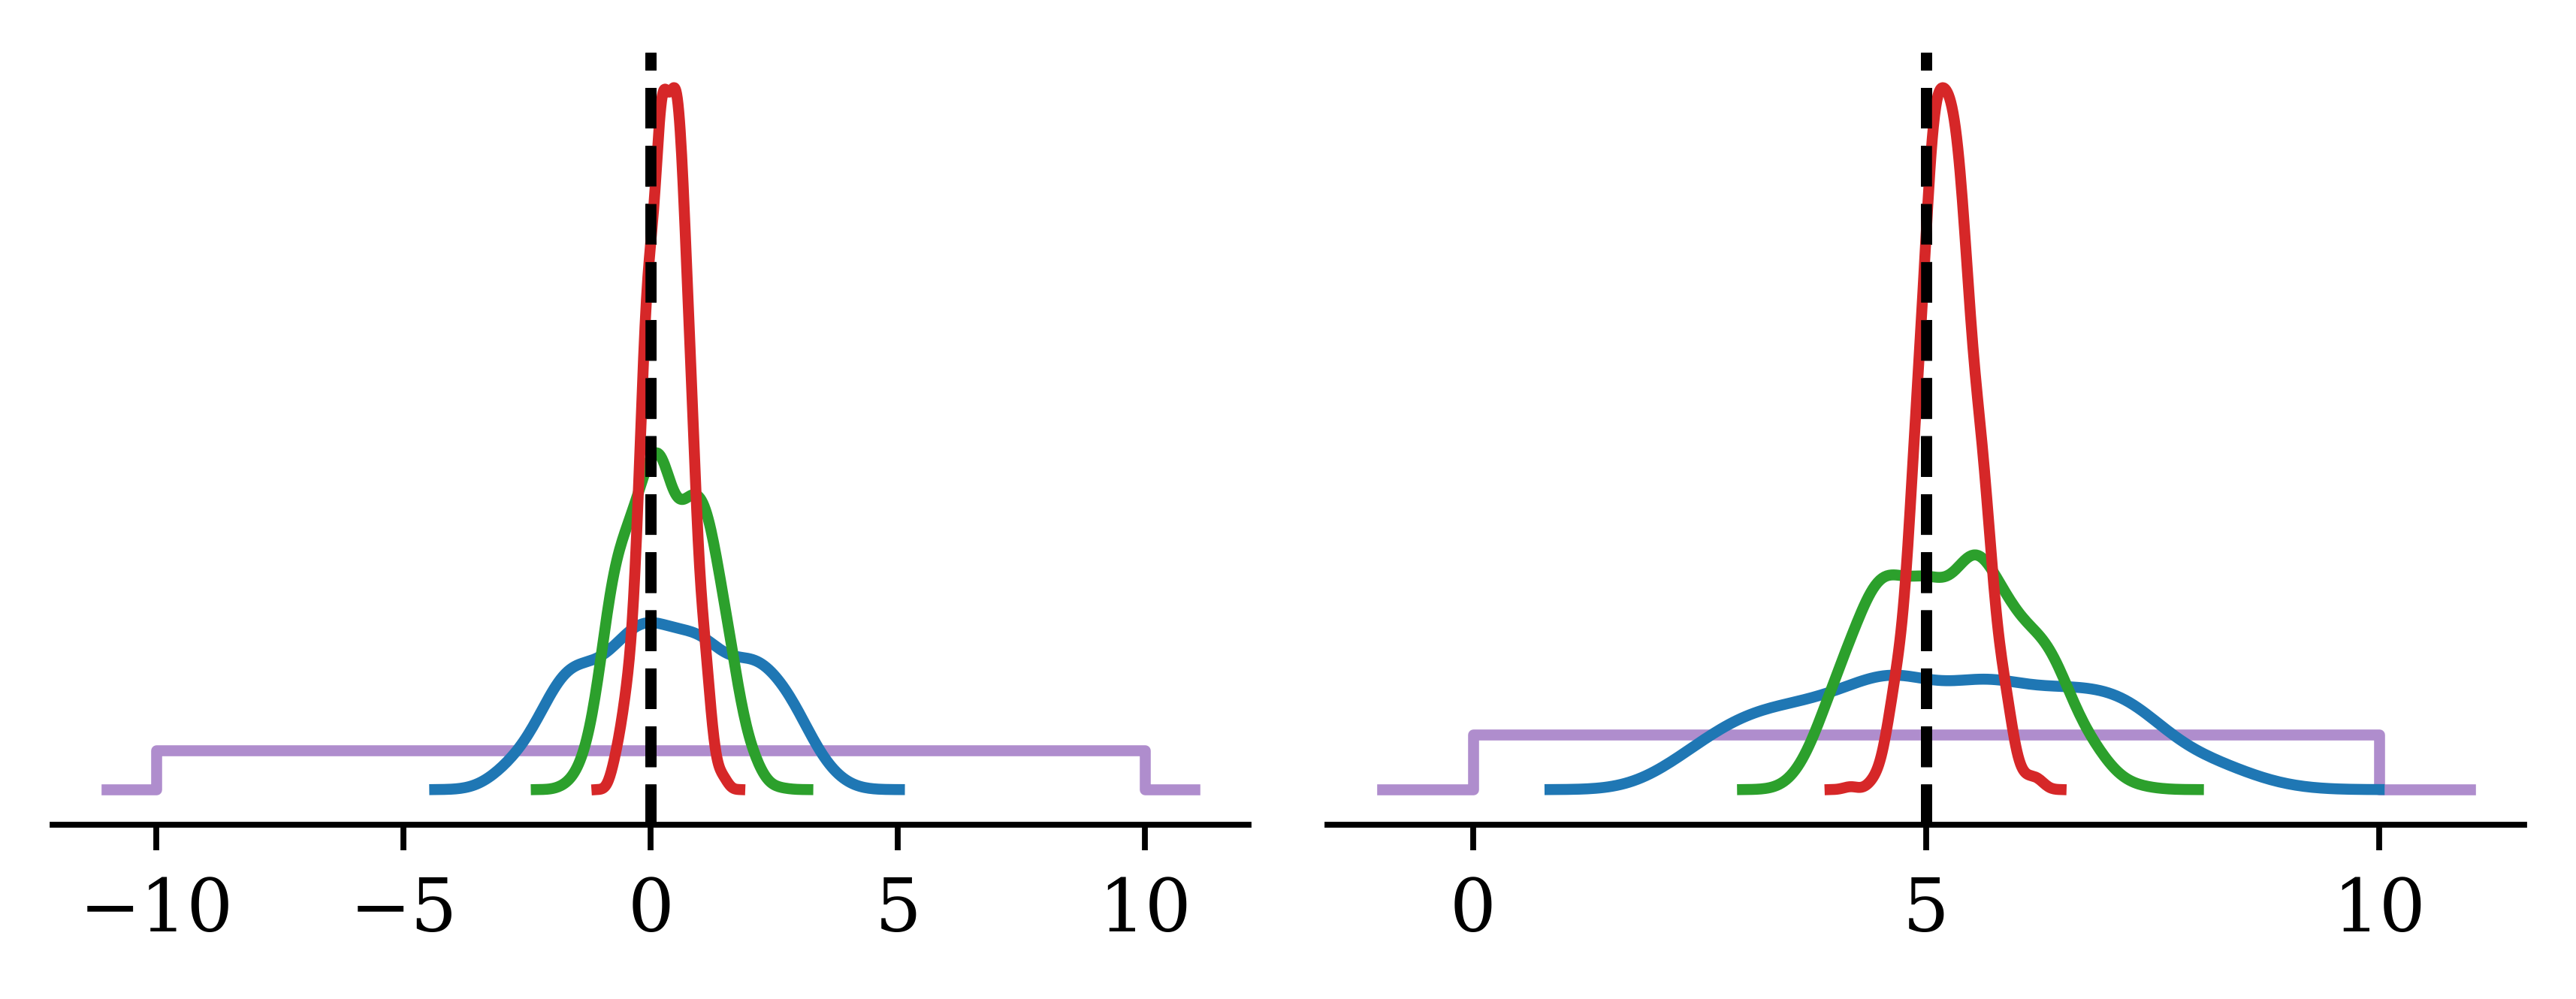

<IPython.core.display.Javascript object>

In [118]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
prior = abcre.IndependentUniformPrior([(-10, 10), (0, 10)], ("mu", "sigma"))

for eps in [50, 25, 10]:
    %time samples, att = abc_ar(priorLower, priorWidth, eps, popSize, seed)

    weights = np.ones(popSize) / popSize

    pLims = [prior.marginals[0].isf(1), prior.marginals[0].isf(0)]
    _, xs, ys = abcre.resample_and_kde(samples[:, 0], weights, clip=pLims)
    axs[0].plot(xs, ys)

    axs[0].axvline(thetaTrue[0], c="k", ls="--")
    axs[0].set_yticks([])
    sns.despine(left=True)

    # plt.subplot(1, 2, 2)
    weights = np.ones(popSize) / popSize

    pLims = [prior.marginals[1].isf(1), prior.marginals[1].isf(0)]
    _, xs, ys = abcre.resample_and_kde(samples[:, 1], weights, clip=pLims)
    axs[1].plot(xs, ys)

    axs[1].axvline(thetaTrue[1], c="k", ls="--")
    axs[1].set_yticks([])
    sns.despine(left=True)


draw_prior(prior, axs)

save_cropped("../Figures/smc-intro.pdf")